# Imports

In [2]:
import json
import requests
import pandas as pd
from http import HTTPStatus
from matplotlib import pyplot as plt
from typing import Iterable, Dict, Union, List

# Activity 1

## 1.1 Sub-activity: Open Data COVID-19 API

### Task 1

In [3]:
# The code for Task 1 is retrieved from https://coronavirus.data.gov.uk/details/developers-guide/main-api

StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]

def get_API_data(filters:FiltersType , structure: StructureType) -> APIResponseType:
    # API URL
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"

    api_params = {
        "filters": "areaType=" + filters["areaType"],
        "structure": json.dumps(structure)
    }

    data = []
    page_number = 1
    
    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = requests.get(endpoint, params=api_params)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f"Request failed: {response.text}")
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        current_data = response.json()
        
        # If there is no data in vaccination_age, set the value to None, otherwise the data will be an empty list
        for age in current_data["data"]:
            if not age["vaccination_age"]:
                age["vaccination_age"] = None

        page_data: List[StructureType] = current_data["data"]
       
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1

    return data

### Task 2

In [4]:
nation_filters = {"areaType":"nation"}
region_filters = {"areaType":"region"}

structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
}

results_json_national = get_API_data(nation_filters, structure)
results_json_regional = get_API_data(region_filters, structure)

## 1.2 Sub-activity: Shaping the COVID data into different dataframes

### Task 3

In [5]:
# Concatenate the two lists of dictionaries
covid_data_list = results_json_national + results_json_regional

### Task 4

In [6]:
# Convert the concatenated list of dictionaries to a pandas dataframe
covid_data = pd.DataFrame(covid_data_list)

### Task 5

In [7]:
# Remove the rows with the value "England" in the dataframe
covid_data.drop(covid_data[covid_data["name"] == "England"].index, inplace=True)

### Task 6

In [8]:
# Rename the column "name" to "area"
covid_data.rename(columns={"name": "area"}, inplace=True)

### Task 7

In [9]:
# Convert the type of date column to datetime from string
covid_data["date"] = pd.to_datetime(covid_data["date"])

### Task 8

In [10]:
# Since the vaccination_age will return a emtpy list if the data isn't available, 
# I set None to the empty list value. 
# Therefore, all the None values will be counted as missing data in the dataframe
nan = covid_data.isna().sum().sum()
print(covid_data.info())
print("\nThe amount of missing data is {}.".format(nan)) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12154 entries, 1044 to 13197
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   12154 non-null  datetime64[ns]
 1   area                   12154 non-null  object        
 2   daily_cases            12140 non-null  float64       
 3   cumulative_cases       12141 non-null  float64       
 4   daily_deaths           10179 non-null  float64       
 5   cumulative_deaths      10192 non-null  float64       
 6   cumulative_vaccinated  7307 non-null   float64       
 7   vaccination_age        7212 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 759.8+ KB
None

The amount of missing data is 13753.


### Task 9

In [11]:
# Fill the missing data of each area with the value of the latest date that has values
covid_data["cumulative_cases"] = covid_data.groupby("area")["cumulative_cases"].fillna(method="bfill")
covid_data["cumulative_deaths"] = covid_data.groupby("area")["cumulative_deaths"].fillna(method="bfill")
covid_data["cumulative_vaccinated"] = covid_data.groupby("area")["cumulative_vaccinated"].fillna(method="bfill")


### Task 10

In [12]:
# Drop the rows with missing data of cumulative metrics
covid_data.drop(covid_data[covid_data["cumulative_deaths"].isnull() == True].index, inplace=True)
covid_data.drop(covid_data[covid_data["cumulative_cases"].isnull() == True].index, inplace=True)
covid_data.drop(covid_data[covid_data["cumulative_vaccinated"].isnull() == True].index, inplace=True)

### Task 11

In [13]:
# The code for rolling average by group of Task 11 is retrieved from https://stackoverflow.com/questions/31121344/sorting-pandas-dataframe-data-within-groupby-groups

# Fill the missing data of daily cases and deaths with 0 to callculate the rolling average
covid_data["daily_cases"].fillna(0, inplace=True)
covid_data["daily_deaths"].fillna(0, inplace=True)

# Create two new dataframes (7-day rolling average of new daily and death cases in each area)
daily_cases_roll_avg = covid_data.sort_values(["area","date"]).groupby("area")["daily_cases"].transform(lambda x: x.rolling(7).mean()).rename("daily_cases_roll_avg")
daily_deaths_roll_avg = covid_data.sort_values(["area","date"]).groupby("area")["daily_deaths"].transform(lambda x: x.rolling(7).mean()).rename("daily_deaths_roll_avg")

# Add the two new columns to the covid_data dataframe
covid_data = pd.concat([covid_data.sort_values(["area","date"]), daily_cases_roll_avg, daily_deaths_roll_avg], axis=1)

### Task 12

In [14]:
# Drop daily_cases and daily_deaths columns
covid_data.drop(columns=["daily_cases", "daily_deaths"],inplace=True)

### Task 13

In [15]:
# Create a new dataframe with the date, area, vaccination_age columns
covid_data_vaccinations = covid_data.loc[:,["date","area","vaccination_age"]]
# Drop the vaccination_age from the covid_data dataframe
covid_data.drop(columns=["vaccination_age"],inplace=True)

### Task 14

In [16]:
# Explode the dictionaries that are inside of the vaccination_age list for each row
exploded = pd.DataFrame(covid_data_vaccinations.explode("vaccination_age", ignore_index=True))

# Since the dictionaries are exploded and the dictionaries are in JSON format, 
# then use the json_normalize function to convert the dictionaries to columns
normalized = pd.json_normalize(exploded["vaccination_age"])

# Concatenate the exploded and normalized dataframes
covid_data_vaccinations_wide = pd.concat([exploded, normalized], axis=1)

# Drop redundant columns
covid_data_vaccinations_wide.drop(columns=[
    "vaccination_age",
    "cumPeopleVaccinatedThirdInjectionByVaccinationDate",
    "newPeopleVaccinatedThirdInjectionByVaccinationDate",
    "cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage",
    "cumPeopleVaccinatedAutumn22ByVaccinationDate",
    "cumPeopleVaccinatedSpring22ByVaccinationDate",
    "newPeopleVaccinatedAutumn22ByVaccinationDate",
    "newPeopleVaccinatedSpring22ByVaccinationDate",
    "cumVaccinationAutumn22UptakeByVaccinationDatePercentage",
    "cumVaccinationSpring22UptakeByVaccinationDatePercentage"
    ], inplace=True)

## 1.3 Sub-activity: Aggregating, plotting, and analysing

### Handling missing data before the 1.3 Sub-activity starts

In [17]:
"""
The way I fill the missing data is to fill the missing data 
with the value of the latest date that has values
"""

"""
Since the Northern Ireland missed from 2022/5/20 to 2022/12/08, 
we need to add more date to the Northern Ireland from 2022/5/20 to 2022/12/8
"""

fill_to_date = "2022-12-08"

# Create a new dataframe with the data of Northern Ireland from covid_data dataframe
Northern_Ireland = covid_data[covid_data["area"] == "Northern Ireland"]

# Create a new dataframe with the date range from 2022/5/20 to 2022/12/8
Northern_Ireland_date_range = pd.DataFrame(pd.date_range(start = "2022-05-20", end = fill_to_date))
Northern_Ireland_date_range.columns = ["date"]

# Add new date to the Northern Ireland dataframe
Northern_Ireland_with_empty_cell = pd.merge(Northern_Ireland, Northern_Ireland_date_range, how = "outer", on = "date")

# Fill the empty data
Northern_Ireland_with_new_data = Northern_Ireland_with_empty_cell.ffill()

# Drop the data of Northern Ireland from the covid_data dataframe
covid_data_drop_Northern_Ireland = covid_data[covid_data["area"] != "Northern Ireland"]

# Add back Northern Ireland with new date to the covid_data dataframe
covid_data_with_new_Northern_Ireland_data = pd.concat([covid_data_drop_Northern_Ireland, Northern_Ireland_with_new_data])

"""
Since the Scotland missed from 2022/12/04 to 2022/12/08, 
we need to add more date to the Scotland from 2022/12/04 to 2022/12/8
"""
Scotland = covid_data[covid_data["area"] == "Scotland"]
Scotland_date_range = pd.DataFrame(pd.date_range(start = "2022-12-04", end = fill_to_date))
Scotland_date_range.columns = ["date"]
Scotland_with_new_data = pd.merge(Scotland, Scotland_date_range, how = "outer", on = "date")
Scotland_with_new_data.ffill(inplace = True)
Northern_Ireland_with_new_date_drop_Scotlant = covid_data_with_new_Northern_Ireland_data[covid_data_with_new_Northern_Ireland_data["area"] != "Scotland"]
covid_data_with_new_data = pd.concat([Northern_Ireland_with_new_date_drop_Scotlant, Scotland_with_new_data])

# Replace the covid_data by covid_data with the new data
covid_data = covid_data_with_new_data

### Task 15

' \n3.0 Answer to Task 15\n\nWe can see from the plot that the cumulative cases in London \nhas been increasing since the beginning of the pandemic, while\nthere are two plateaus in the plot. The first plateau is from\nthe end of January to july in 2021, and the second plateau\nis from the beginning of April to the end of the year (slightly increased). \n'

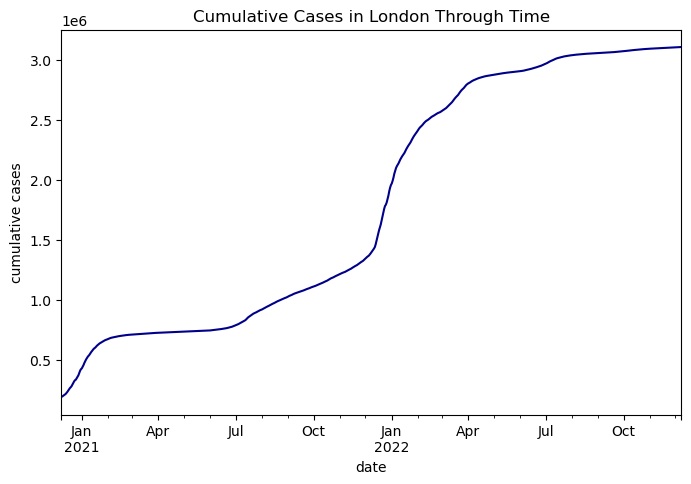

In [18]:
# 1.0 Intermediate dataframe
cumulative_cases_in_London_through_time = covid_data[covid_data["area"] == "London"].groupby("date")["cumulative_cases"].sum()

# 2.0 Plot to intermediate dataframe
cumulative_cases_in_London_through_time.plot(x = "date", y = "cumulative_cases", figsize = (8,5), ylabel = "cumulative cases", title = "Cumulative Cases in London Through Time", color = "darkblue")

""" 
3.0 Answer to Task 15

We can see from the plot that the cumulative cases in London 
has been increasing since the beginning of January 2021, while
there are two plateaus in the plot. The first plateau is from
the end of January to july in 2021, and the second plateau
is from the beginning of April to the end of the year (slightly increased). 
"""

### Task 16

'\n3.0 Answer to Task 16\n\nWe can see from the plot that the cumulative cases in all areas\nis almost the same as the cumulative cases in London. Additionally, \nat the beginning of January 2021 the cumulative cases of London \nincreased more than that in all areas. Whereas from July 2021 to \nJanuary 2022 the slope of the cumulative cases in all areas is higher \nthan that in London.\n'

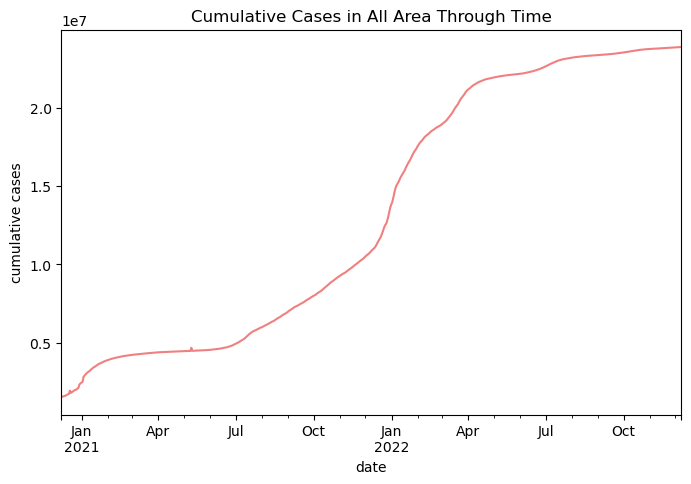

In [19]:
# 1.0 Intermediate dataframe
cumulative_cases_summed_over_all_areas = covid_data.groupby("date")["cumulative_cases"].sum()

# 2.0 Plot to intermediate dataframe
cumulative_cases_summed_over_all_areas.plot(figsize = (8,5), ylabel = "cumulative cases", title = "Cumulative Cases in All Area Through Time", color = "lightcoral")

"""
3.0 Answer to Task 16

We can see from the plot that the cumulative cases in all areas
is almost the same as the cumulative cases in London. Additionally, 
at the beginning of January 2021 the cumulative cases of London 
increased more than that in all areas. Whereas from July 2021 to 
January 2022 the slope of the cumulative cases in all areas is higher 
than that in London.
"""

### Task 17

'\n3.0 Answer to Task 17\n\nWe can see from the plot that a pattern that all nations and regions shares is that\nthe cumulative cases in all areas increased slowly since the beginning of the pandemic, \nand then increased rapidly from July 2021 to April 2022, after which the cumulative cases \nincreased slowly and then plateaud to the end of the year. However, the cumulative cases \nin North East had a spur in the beginning of the May 2021.\n'

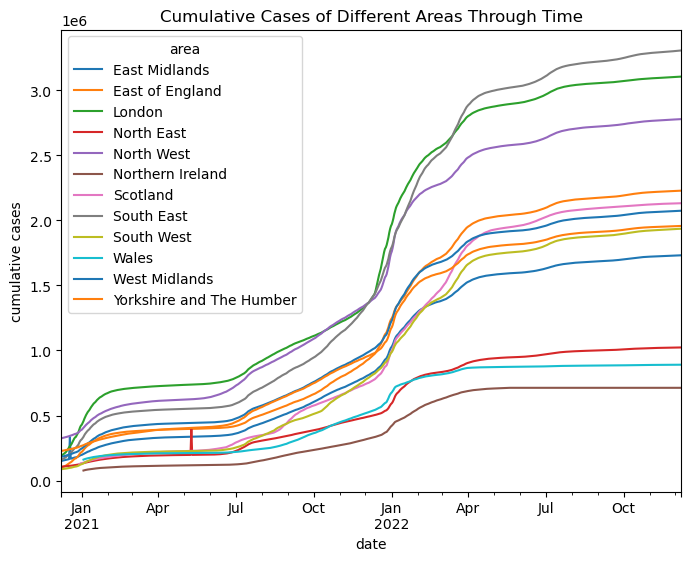

In [20]:
# 1.0 Intermediate dataframe
cumulative_cases_of_different_areas = covid_data.groupby(["date","area"])["cumulative_cases"].sum().unstack()

# 2.0 Plot to intermediate dataframe
cumulative_cases_of_different_areas.plot(figsize=(8, 6), title = "Cumulative Cases of Different Areas Through Time", ylabel="cumulative cases", xlabel="date")

"""
3.0 Answer to Task 17

We can see from the plot that a pattern that all nations and regions shares is that
the cumulative cases in all areas increased slowly since the beginning of Januara 2021, 
and then increased rapidly from July 2021 to April 2022, after which the cumulative cases 
increased slowly and then plateaud to the end of the year. However, the cumulative cases 
in North East had a spur in the beginning of the May 2021.
"""

### Task 18

In [21]:
"""
Answer to Task 18

There are two possible events that could cause the trend in June-July 2021. 

Firstly, this happened might be because of the covid variant. 

Secondly, the restriction of covid lockdown was lifted in England on 19 July 2021, 
which could lead to a constant increase in the cumulative cases in England until April 2022.
"""

'\nAnswer to Task 18\n\nThere are two possible events that could cause the trend in June-July 2021. \n\nFirstly, this happened might be because of the covid variant. \n\nSecondly, the restriction of covid lockdown was lifted in England on 19 July 2021, \nwhich could lead to a constant increase in the cumulative cases in England until April 2022.\n'

### Task 19

'\n3.0 Answer to Task 19\n\nYes, there was a noticeable period that broke the ongoing trend \nof the cumulative deaths in London. It was at the end of March 2021\n'

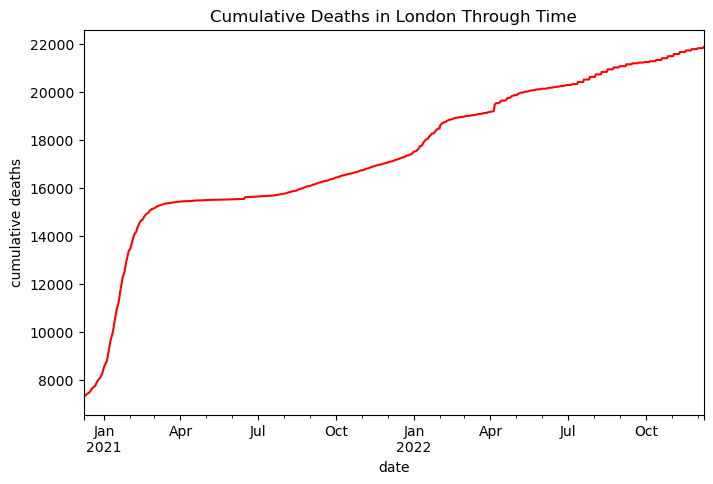

In [22]:
# 1.0 Intermediate dataframe
cumulative_deaths_in_London = covid_data[covid_data["area"] == "London"].groupby("date")["cumulative_deaths"].sum()

# 2.0 Plot to intermediate dataframe
cumulative_deaths_in_London.plot(title = "Cumulative Deaths in London Through Time", ylabel = "cumulative deaths", figsize = (8,5), color = "red")

"""
3.0 Answer to Task 19

Yes, there was a noticeable period that broke the ongoing trend 
of the cumulative deaths in London. It was at the end of March 2021
"""

### Task 20

In [23]:
"""
Answer to Task 20

There are three similarites between the cumulative cases and the cumulative deaths in London.

Firstly, the cumulative cases and the cumulative deaths in London increase rapidly from the 
beginning of January 2021.

Secondly, the cumulative cases and the cumulative deaths in London increase slowly from the 
end of March 2021. 

Finally, the cumulative cases and the cumulative deaths in London had a constant increase since
the end of March 2021 until the end of the year although the cumulative cases in London had a 
time that increased rapidly than cumulative deaths.
"""

'\nAnswer to Task 20\n\nThere are three similarites between the cumulative cases and the cumulative deaths in London.\n\nFirstly, the cumulative cases and the cumulative deaths in London increase rapidly from the \nbeginning of January 2021.\n\nSecondly, the cumulative cases and the cumulative deaths in London increase slowly from the \nend of March 2021. \n\nFinally, the cumulative cases and the cumulative deaths in London had a constant increase since\nthe end of March 2021 until the end of the year although the cumulative cases in London had a \ntime that increased rapidly than cumulative deaths.\n'

### Task 21

'\n3.0 Answer to Task 21\n\nOverall, there was a downward trend in the cumulative deaths per cases \nfrom the beginning of the pandemic to the end of 2022. \n'

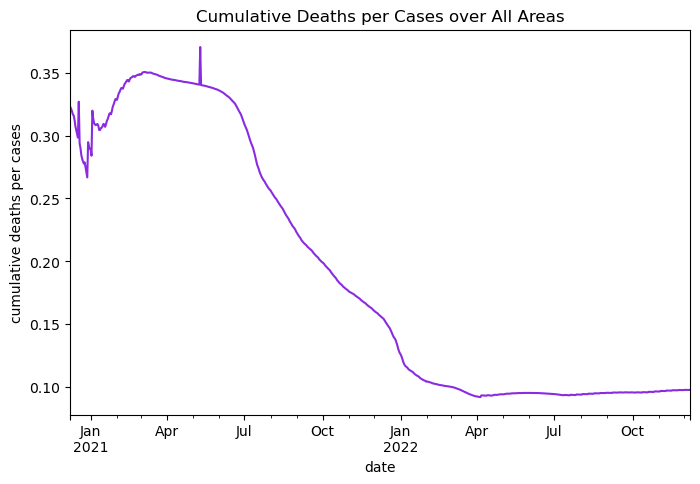

In [24]:
# 1.0 Intermediate dataframe
# Create a new column in covid_data which is cumulative_deaths_per_cases
covid_data["cumulative_deaths_per_cases"] = covid_data["cumulative_deaths"] / covid_data["cumulative_cases"]
cumulative_deaths_per_cases = covid_data.groupby("date")["cumulative_deaths_per_cases"].sum()


# 2.0 Plot to intermediate dataframe
cumulative_deaths_per_cases.plot(title = "Cumulative Deaths per Cases over All Areas", ylabel = "cumulative deaths per cases", figsize = (8,5), color = "blueviolet")

"""
3.0 Answer to Task 21

Overall, there was a downward trend in the cumulative deaths per cases 
from the beginning of January 2021 to the end of 2022. 
"""

### Task 22

In [25]:
"""
Answer to Task 22

One reasonable reason for the inclination gets steeper in June-July 
could be people were getting vaccinated at that time.
"""

'\nAnswer to Task 22\n\nOne reasonable reason for the inclination gets steeper in June-July \ncould be people were getting vaccinated at that time.\n'

### Task 23

"\nAnswer to Task 23\n\nOne possible relationship between Task 23 and Task 21's plot is that \nafter more and more people were vaccinated, the cumulative deaths per cases decreased, which\nmeans that the vaccination could be effective in reducing the deaths and the situation of the\npandemic was under control.\n"

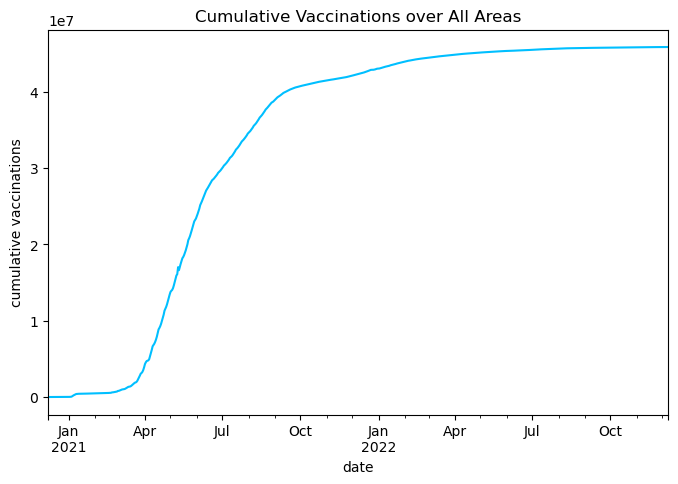

In [26]:
# 1.0 Intermediate dataframe
cumulative_vaccinations_over_all_areas = covid_data.groupby("date")["cumulative_vaccinated"].sum()

# 2.0 Plot to intermediate dataframe
cumulative_vaccinations_over_all_areas.plot(title = "Cumulative Vaccinations over All Areas", ylabel = "cumulative vaccinations", figsize = (8,5), color = "deepskyblue")

"""
Answer to Task 23

One possible relationship between Task 23 and Task 21's plot is that 
after more and more people were vaccinated, the cumulative deaths per cases decreased, which
means that the vaccination could be effective in reducing the deaths and the situation of the
covid-19 was under control.
"""

### Task 24

'\nAnswer to Task 24\n\nThere are two areas that seem to escape the trend of the daily cases rolling average, \nnamely Northern Ireland and Scotland. \n\nI filled with empty values for Northern Ireland from 2022/5/20 to 2022/12/08 and \nfor Scotland from 2022/12/04 to 2022/12/08. By looking at the data that was before \n2022/5/20 of Northern Ireland, Northern Ireland did not have as many as peak cases \nfrom July 2021 to the beginning of January 2022 as the other areas. and by looking \nat the data that was before 2022/12/04 of Scotland, Scotland did not have as many as \npeak cases as the other areas from April 2022 to the end of 2022.\n'

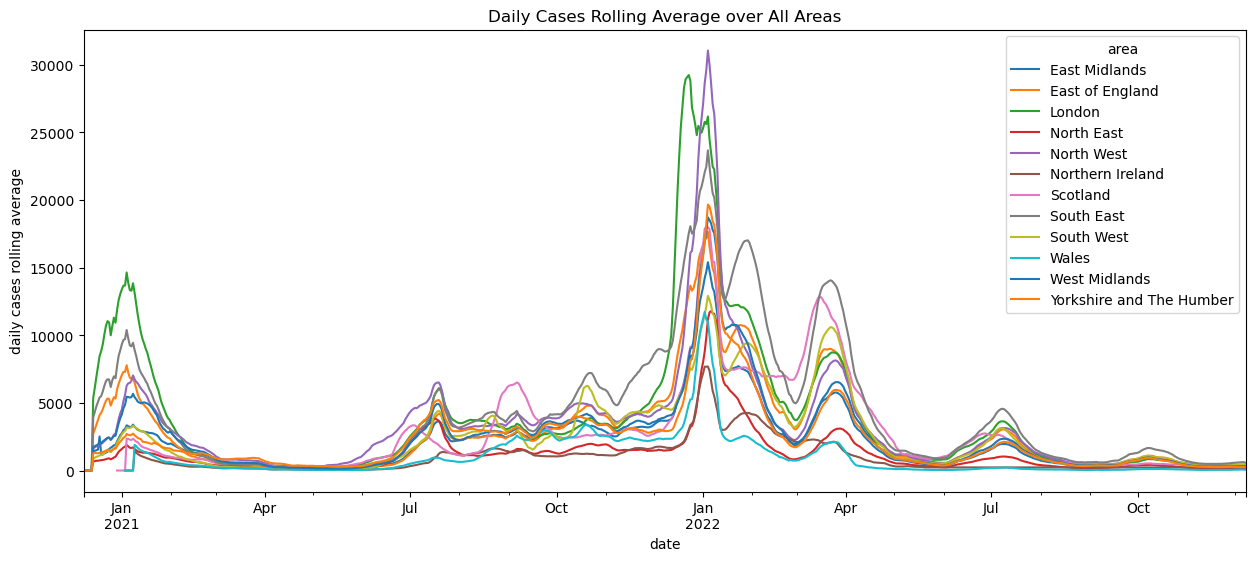

In [71]:
# 1.0 Intermediate dataframe
daily_cases_rolling_average_separated_by_areas = covid_data.groupby(["date","area"])["daily_cases_roll_avg"].sum().unstack()

# 2.0 Plot to intermediate dataframe
daily_cases_rolling_average_separated_by_areas.plot(figsize=(15, 6), title = "Daily Cases Rolling Average over All Areas", ylabel="daily cases rolling average", xlabel="date")

"""
Answer to Task 24

The general trend of the daily cases rolling average is that the daily cases rolling average obviously
peaked around in July 2021, mid of July 2021, mid of October 2021, January 2022, mid of April 2022, 
July 2022, and beginning of October 2022. There are four areas that seem to escape the general trend of 
the daily cases rolling average, namely Northern Ireland, North East, Wales, and Scotland.

Overall, the daily cases rolling average in these did not peak as much as the other areas
in the beginning of January 2021. From July 2021 to December 2021, the daily cases rolling average
was more flat than the other areas.

However, the daily cases rolling average in Scotland almost followed the general trend of the daily cases.
There was a peak in September 2021 which was prior to the peak in the other areas in the mid of October 2021.
As a result, the daily cases rolling average in Scotland could be considered to be one of the areas that seems to
escape the general trend.
"""

### Task 25

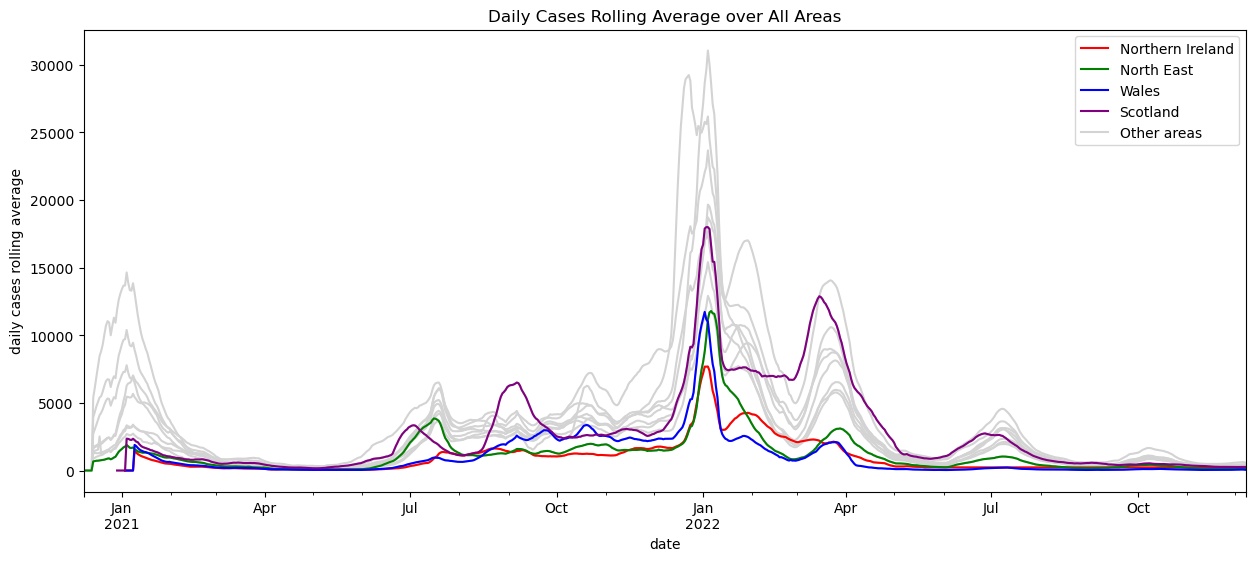

'\nAnswer to Task 25\n\nThere are two factors comtributing to the difference between the daily cases rolling average, \nnamely geographical location and population density.\n\nFirstly, the geographical location of Northern Ireland, North East, Wales, and Scotland are\n\nSecondly, the population density of Northern Ireland, North East, Wales, and Scotland are\n\n'

In [112]:
# 1.0 Intermediate dataframe
daily_cases_rolling_average_Northern_Ireland = covid_data[covid_data["area"] == "Northern Ireland"].groupby(["date"])["daily_cases_roll_avg"].sum()
daily_cases_rolling_average_North_East = covid_data[covid_data["area"] == "North East"].groupby(["date"])["daily_cases_roll_avg"].sum()
daily_cases_rolling_average_Wales = covid_data[covid_data["area"] == "Wales"].groupby(["date"])["daily_cases_roll_avg"].sum()
daily_cases_rolling_average_Scotland = covid_data[covid_data["area"] == "Scotland"].groupby(["date"])["daily_cases_roll_avg"].sum()

# 2.0 Plot to intermediate dataframe
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
daily_cases_rolling_average_separated_by_areas.plot(ax=ax, color = "lightgrey")
daily_cases_rolling_average_Northern_Ireland.plot(ax=ax, color = "red")
daily_cases_rolling_average_North_East.plot(ax=ax, color = "green")
daily_cases_rolling_average_Wales.plot(ax=ax, color = "blue")
daily_cases_rolling_average_Scotland.plot(ax=ax, color = "purple")
plt.title("Daily Cases Rolling Average over All Areas")
plt.ylabel("daily cases rolling average")
plt.legend(["Northern Ireland", "North East", "Wales", "Scotland", "Other areas"])
ax.get_legend().legendHandles[0].set_color("red")
ax.get_legend().legendHandles[1].set_color("green")
ax.get_legend().legendHandles[2].set_color("blue")
ax.get_legend().legendHandles[3].set_color("purple")
ax.get_legend().legendHandles[4].set_color("lightgrey")
plt.show()

"""
Answer to Task 25

There are two factors comtributing to the difference between the daily cases rolling average, 
namely geographical location and population density.

Firstly, the geographical location of Northern Ireland, North East, Wales, and Scotland are far away
from the center of the covid-19 outbreak, which is London. As a result, the daily cases rolling average

Secondly, the population density of Northern Ireland, North East, Wales, and Scotland are

"""


### Task 26

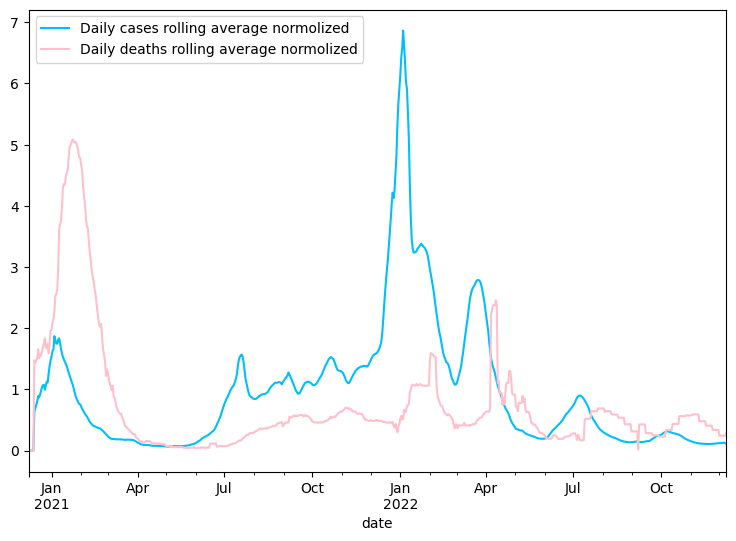

In [29]:
# 1.0 Intermediate dataframe
covid_data["daily_cases_roll_avg_norm"] = covid_data["daily_cases_roll_avg"] / covid_data["daily_cases_roll_avg"].max()
covid_data["daily_deaths_roll_avg_norm"] = covid_data["daily_deaths_roll_avg"] / covid_data["daily_deaths_roll_avg"].max()
covid_data.groupby("date")["daily_cases_roll_avg_norm"].sum().plot(figsize=(9, 6), color = "deepskyblue")
covid_data.groupby("date")["daily_deaths_roll_avg_norm"].sum().plot(figsize=(9, 6), color = "pink")

# 2.0 Plot to intermediate dataframe
plt.legend(["Daily cases rolling average normolized", "Daily deaths rolling average normolized"])

"""
Answer to Task 26


"""

### Task 27

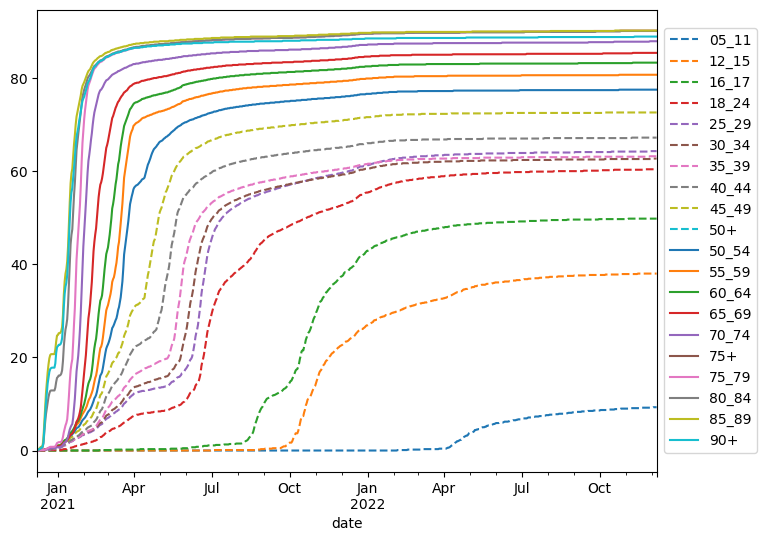

In [30]:
# 1.0 Intermediate dataframe
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "London"]
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "Scotland"]

covid_data_vaccinations_wide_london = covid_data_vaccinations_wide_london[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
columns = covid_data_vaccinations_wide_london.groupby('date')['age'].apply(list)[0]
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide_london.groupby('date')['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'].apply(list).apply(pd.Series)
covid_data_vaccinations_wide_london.columns=columns
covid_data_vaccinations_wide_london.reset_index(inplace=True)

# 2.0 Plot to intermediate dataframe
covid_data_vaccinations_wide_london.plot(figsize=(8, 6), x="date", y=columns, style=["--" for _ in range(10)])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

"""
Answer to Task 27

"""

### Task 28

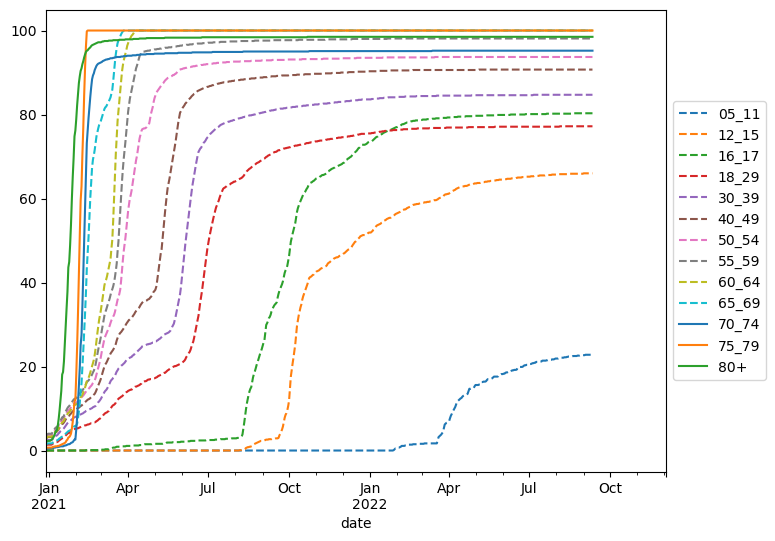

In [31]:
# 1.0 Intermediate dataframe
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide_scotland[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
columns = covid_data_vaccinations_wide_scotland.groupby('date')['age'].apply(list)[0]
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide_scotland.groupby('date')['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'].apply(list).apply(pd.Series)
covid_data_vaccinations_wide_scotland.columns=columns
covid_data_vaccinations_wide_scotland.reset_index(inplace=True)

# 2.0 Plot to intermediate dataframe
covid_data_vaccinations_wide_scotland.plot(figsize=(8, 6), x="date", y=columns, style=["--" for _ in range(10)])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

"""
Answer to Task 28

"""